In [1]:
import torch
import csv
import math

import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.metrics import infidelity, sensitivity_max, infidelity_perturb_func_decorator

from helpers import get_labels, get_input_image, predict

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#ffffff'),
                                                  (1, '#000000')], N=256)
torch.manual_seed(42)
np.random.seed(42)

## Initialize Resnet18

[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [2]:
# Equates to one random 6x6 image
random_data = torch.rand((5, 1, 6, 6))
random_y = torch.tensor([[0,1], [0,1], [1,0], [0,1], [1,0]])
# random_y = torch.randint(low=0, high=2, size=(5,2), dtype=torch.float32)

# my_nn = Net()
# result = my_nn(random_data)
# print (my_nn)
# print(result)
# print(random_data)
# print(random_y)

In [37]:
df = pd.DataFrame([["a", 2], ["b", 2], ["c", 3]], columns=[["path", "class"]])

In [38]:
df

,path,class
0,a,2
1,b,2
2,c,3


In [39]:
new_df = pd.DataFrame()

In [43]:
for rotation in range(-20, 30, 10):
    print(rotation, str(rotation))
    df1 = df.copy()
    df1['rotation'] = str(rotation)
    new_df = pd.concat([new_df, df1], ignore_index=True)

-20 -20
-10 -10
0 0
10 10
20 20


In [48]:
int(new_df.iloc[0]['rotation'])

-20

In [42]:
pd.concat([new_df, df1], ignore_index=True)

,path,class,rotation
0,a,2,20
1,b,2,20
2,c,3,20


In [4]:
size = 3
x = torch.rand((5, 1, size, size))
y = torch.tensor([[0,1], [0,1], [1,0], [0,1], [1,0]])
loss_fn = torch.nn.MSELoss(reduction='sum')
D_in = (1,6,6)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(size*size, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.Softmax(1)
)

learning_rate = 1e-2
for t in range(2000):
#     print(x.shape)
    y_pred = model(x)
    y = y.to(torch.float32)
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


99 2.137282609939575
199 1.4483171701431274
299 0.5370581150054932
399 0.20430247485637665
499 0.10530705749988556
599 0.06592129170894623
699 0.04625856131315231
799 0.03490527719259262
899 0.02766229212284088
999 0.022705908864736557
1099 0.019133564084768295
1199 0.016454190015792847
1299 0.014380457811057568
1399 0.01273411326110363
1499 0.011399404145777225
1599 0.010298253037035465
1699 0.009376081638038158
1799 0.008593873120844364
1899 0.007922956719994545
1999 0.007341901771724224


In [6]:
torch.save(model, './model.pkl')

In [7]:
model = torch.load('./model.pkl')
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=9, out_features=4, bias=True)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=2, bias=True)
  (4): Softmax(dim=1)
)

In [8]:
x_test = torch.rand((1, 1, size, size))
model.eval()
print(x[0].unsqueeze(0).shape)
result = model(x_test)
print(result)

torch.Size([1, 1, 3, 3])
tensor([[0.9889, 0.0111]], grad_fn=<SoftmaxBackward>)


In [9]:
sali = Saliency(model)
attributions_sali = sali.attribute(x_test, target=0)

/home/piro/anaconda3/envs/assignment-1-burnpiro/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [10]:
print(attributions_sali.shape)
print(x_test.shape)

print(attributions_sali.squeeze(0).cpu().detach().numpy())
print(x_test.squeeze(0).cpu().detach().numpy())

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 3, 3])
[[[0.00123872 0.02467672 0.04930959]
  [0.10108921 0.02213562 0.02685863]
  [0.08070823 0.00076442 0.01712421]]]
[[[0.04094696 0.8343076  0.14735395]
  [0.6872336  0.92312264 0.5070212 ]
  [0.9549045  0.07397425 0.3090204 ]]]


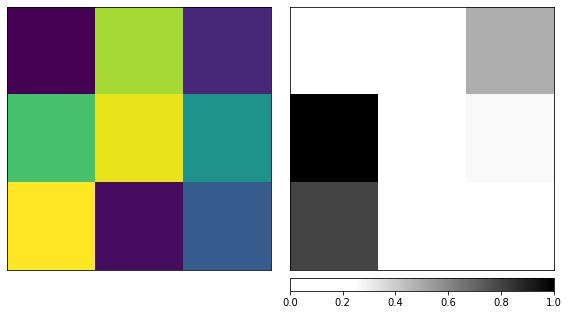

In [11]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_sali.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(x_test.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [12]:
sample_input = torch.tensor([[[[0, 0, 0],
  [0,  0.49, 0],
  [0,  0, 0]]]])

sample_noise = torch.tensor([[[[0, 0,   0],
  [ 0,  0.40, 0.0],
  [0, 0.0,  0 ]]]])
sample_diff = sample_input - sample_noise
att_sam_in = sali.attribute(sample_input, target=0)
att_sam_diff = sali.attribute(sample_diff, target=0)

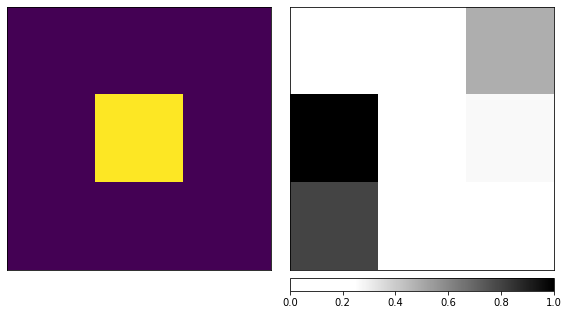

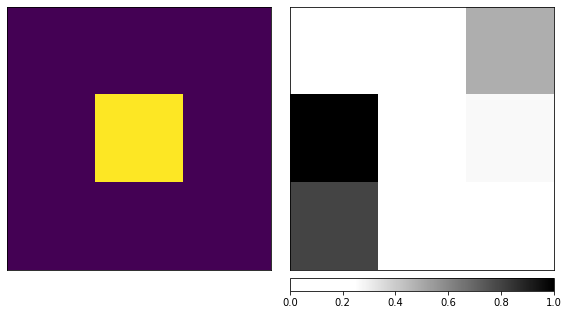

In [13]:
_ = viz.visualize_image_attr_multiple(np.transpose(att_sam_in.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(sample_input.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
_ = viz.visualize_image_attr_multiple(np.transpose(att_sam_diff.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(sample_diff.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [14]:
print(model(sample_input))
print(model(sample_diff))


print(sample_input)
print(sample_diff)

print(att_sam_in)
print(att_sam_diff)

tensor([[0.2107, 0.7893]], grad_fn=<SoftmaxBackward>)
tensor([[0.1068, 0.8932]], grad_fn=<SoftmaxBackward>)
tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.4900, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0900, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
tensor([[[[0.0187, 0.3727, 0.7447],
          [1.5266, 0.3343, 0.4056],
          [1.2189, 0.0115, 0.2586]]]])
tensor([[[[0.0107, 0.2136, 0.4269],
          [0.8752, 0.1916, 0.2325],
          [0.6988, 0.0066, 0.1483]]]])


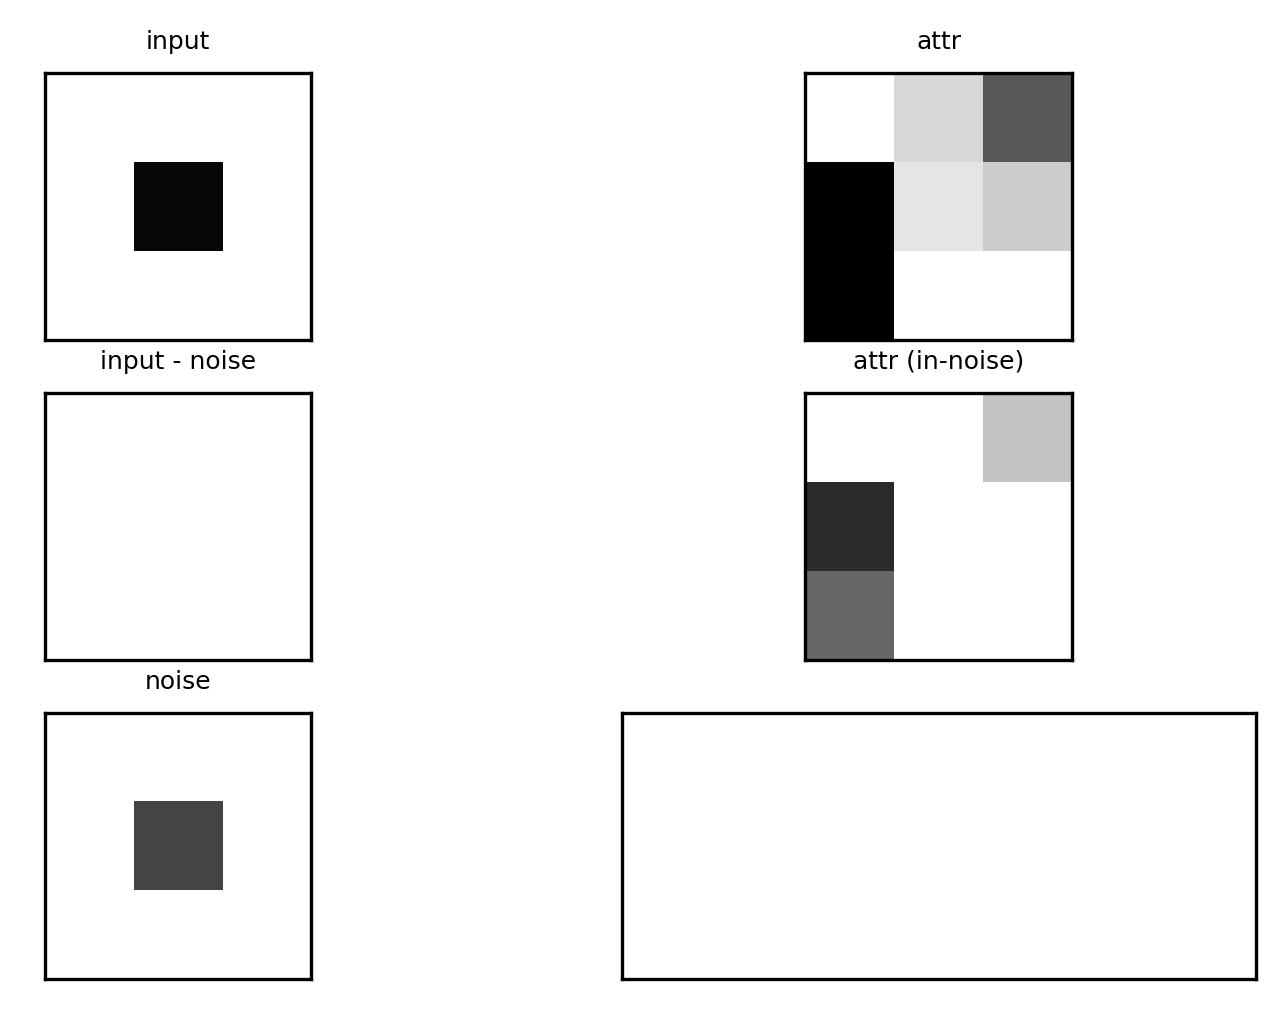

In [15]:
fig, ax = plt.subplots(3, 2, dpi=300)

# tensor([[[[0.3312, 0.6058, 0.1969],
#           [0.0613, 0.2893, 0.0752],
#           [0.4238, 0.1407, 0.4040]]]])
# tensor([[[[0.4997, 0.8028, 0.3548],
#           [0.2774, 0.4064, 0.1228],
#           [0.5218, 0.3199, 0.3999]]]])

ax[0,0].imshow(np.transpose(sample_input[0].cpu().detach().numpy(), (1,2,0)),
                                      cmap=default_cmap, vmax=0.5)
ax[0,0].set_title('input', fontsize=6)
ax[0,1].imshow(np.transpose(att_sam_in[0].cpu().detach().numpy(), (1,2,0)),
                                      cmap=default_cmap, vmax=1)
ax[0,1].set_title('attr', fontsize=6)
ax[1,0].imshow(np.transpose(sample_diff[0].cpu().detach().numpy(), (1,2,0)),
                                      cmap=default_cmap, vmax=0.5)
ax[1,0].set_title('input - noise', fontsize=6)
ax[1,1].imshow(np.transpose(att_sam_diff[0].cpu().detach().numpy(), (1,2,0)),
                                      cmap=default_cmap, vmax=1)
ax[1,1].set_title('attr (in-noise)', fontsize=6)
ax[2,0].imshow(np.transpose(sample_noise[0].cpu().detach().numpy(), (1,2,0)),
                                      cmap=default_cmap, vmax=0.5)
ax[2,0].set_title('noise', fontsize=6)
# ax[1].imshow(np.transpose(att_sam_in[0].cpu().detach().numpy(), (1,2,0)),
#                                       cmap=default_cmap)
# ax[1].imshow(att_sam_in[0])

for ax_gr in ax:
    for ax_el in ax_gr:
        ax_el.get_xaxis().set_visible(False)
        ax_el.get_yaxis().set_visible(False)
    

### Calculate Infidelity and Sensitivity metrics

[On the (In)fidelity and Sensitivity for Explanations](https://arxiv.org/abs/1901.09392)

In [149]:
# We need that for metric calculation
x_test.requires_grad = True

In [150]:
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
#     print(noise)
#     noise = torch.tensor([[[[0, 0,   0],
#       [ 0,  0.5, 0.0],
#       [0, 0.0,  0]]]])
    noise = sample_noise
    diff = inputs - noise
    return noise, inputs - noise

infid = infidelity(model, perturb_fn, sample_input, att_sam_in, target=0, n_perturb_samples=1)
print('{:.9f}'.format(infid.numpy()[0]))

0.000025381


In [151]:
sens = sensitivity_max(sali.attribute, sample_input, target=0)

In [152]:
print(f"Infidelity: {infid.numpy()[0]}, Sensitivity: {sens.numpy()[0]}")

Infidelity: 2.5380924853379838e-05, Sensitivity: 0.0
